In [1]:
using ReactiveMP, Rocket, GraphPPL
using Random, Distributions, Plots, LinearAlgebra
using KernelFunctions

## Solve GP regression by SDE 
In this notebook, we try to solve a GP regression problem by using SDE (ref: Solin, Arno. "Stochastic differential equation methods for spatio-temporal Gaussian process regression." (2016).) 

The kernel we use is Matern-3/2


## State space model

In [84]:
@model function gp_regression(n, A, Q, H)
    f_0 ~ MvNormalMeanCovariance([0., 0.], P∞)

    f = randomvar(n)
    y = datavar(Float64,n)

    f_prev = f_0
    for i=1:n
        f[i] ~ MvNormalMeanCovariance(A * f_prev, Q)
        y[i] ~ NormalMeanVariance(dot(H , f[i]), 0.2)
        f_prev = f[i]
    end

    return f, y
end

## Inference

In [85]:
function infer(data,A,Q,H)
    n = length(data)
    model, (f,y) = gp_regression(n,A,Q,H)
    
    f_buffer = buffer(Marginal, n)

    f_subscribed = subscribe!(getmarginals(f), f_buffer) #error here

    update!(y,data)

    unsubscribe!(f_subscribed)

    return f_buffer
end

infer (generic function with 2 methods)

## Generate data

In [206]:
#generate data
Random.seed!(10)
x_input = range(0, 5, length=100); #input
f_true = 2*sin.(x_input) .+ cos.(2*x_input); # true process

pos = sort(randperm(length(x_input))[10:2:100]); # position where we observe data
x_obser = x_input[pos]; # x-positions of observed point
y_obser = f_true[pos] + 0.2*randn(length(x_obser)); # noisy observation

θ = [0.1, 1., 1., 0.2]; # store [Δt, l, σ², σ²_noise]
λ = sqrt(3.)/θ[2];
P∞ = [θ[3] 0.; 0. (λ^2*θ[3]) ]
F = [0. 1.; -λ^2 -2*λ];
A = exp(F * θ[1]);
H = [1.; 0.];
Q = P∞ - A*P∞*A';

## Execution

In [207]:
f_posterior = infer(y_obser, A,Q,H);

In [208]:
m_f = Array{Array{Float64}}(undef, length(y_obser))
cov_f = Array{Array{Float64}}(undef, length(y_obser))
for i=1:length(y_obser)
    m_f[i] = mean_cov.(f_posterior)[i][1]
    cov_f[i] = mean_cov.(f_posterior)[i][2]
end

In [209]:
var_f = []
for i=1:length(y_obser)
    append!(var_f,cov_f[i][1])
end

In [210]:
M_F = hcat(m_f...)

2×46 Matrix{Float64}:
 1.16889   1.24458   1.31753   1.38787   …  -2.82766   -2.75861   -2.66681
 0.785199  0.739121  0.717691  0.688904      0.561565   0.794823   1.08483

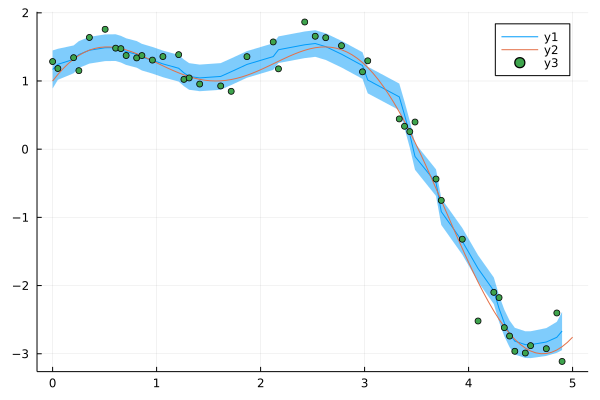

In [211]:
plot(x_obser, M_F[1,:], ribbon = sqrt.(var_f))
plot!(x_input,f_true)
scatter!(x_obser,y_obser)